In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from test_utils import *
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import wes

In [137]:
if 1:
    with open('/Users/bwq666/Documents/BoxHed/sim_data/DMLvsCox.pkl','rb') as f:
        sim_data = pickle.load(f)

In [138]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath}')
path = '/Users/bwq666/Documents/BoxHed/Plots'; chdir(path)

In [139]:
sns.set_palette('muted')

In [140]:
# df_endpoints = pd.melt(
#     sim_data, id_vars=['n_sample','alt_param','beta1','kernel_X'],value_vars=['gam_plug','gam_corrected','gam_double'] #no point in checking power of a test with no level
# )
# if len(df_endpoints['beta1'].unique()) > 1:
#     params = r'$(\gamma,\beta,k)$'
#     df_endpoints[params] = list(zip(df_endpoints.alt_param,df_endpoints.beta1,df_endpoints.kernel_X))

# else:
#     params = 'dependency'
#     df_endpoints[params] = df_endpoints.alt_param

# df_endpoints.head(4)

In [141]:
# g = sns.FacetGrid(df_endpoints, col='n_sample', row=params, hue='variable',sharex=False,sharey=False)
# g.map(sns.distplot, 'value');
# g.add_legend()
# g.refline(x=0, linewidth=1, linestyle=':',color='k', clip_on=False)
# g.set_titles(size='x-small')
# g.set(yticks=[], ylabel="")
# plt.savefig('endpoints.pdf')
# plt.show()

In [142]:
p_value = lambda x: 1-BM_supnorm_cdf(np.sqrt(x[2])*x[0]/np.sqrt(x[1])) # x = (statistic, variance, samplesize)
p_value_double = lambda x: 1-BM_supnorm_cdf(np.sqrt(x[2])*x[0]/np.sqrt(x[1])) # x = (statistic, variance, samplesize)
#sim_data['p_plug'] = sim_data[['T_plug','sigma','n_sample']].apply(p_value_corr,axis=1)
sim_data['p_orth'] = sim_data[['T_corrected','sigma','n_sample']].apply(p_value,axis=1)
sim_data['p_double'] = sim_data[['T_double','sigma_double','n_sample']].apply(p_value,axis=1)

In [147]:
df_pvals = pd.melt(
    sim_data, id_vars=['n_sample','alt_param','beta1','kernel_X'],value_vars=['p_double','p_cox']
)
if len(df_pvals['beta1'].unique()) > 1:
    parameter_name = r'$(\beta,k)$'
    df_pvals[parameter_name] = list(zip(df_pvals.beta1.astype(int),df_pvals.kernel_X))
else:
    parameter_name = r'dependency'
    df_pvals[parameter_name] = df_pvals.alt_param

In [148]:
df = df_pvals.rename(columns={"n_sample": r"$n$"})
df = df[(df['alt_param']==0) & (df['variable']=='p_double')]

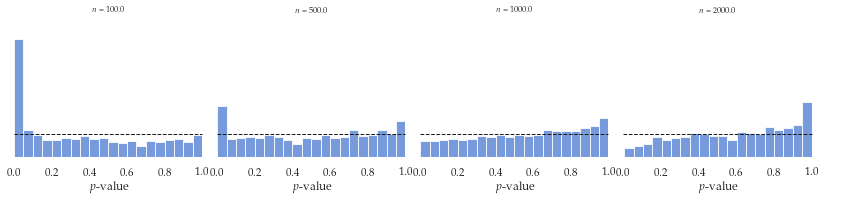

In [149]:
g = sns.FacetGrid(df,col=r"$n$", sharey=True,sharex=True)
# g = sns.FacetGrid(df_pvals, col='n_sample',row=parameter_name,hue='variable',sharex=False)
g.map(
    sns.histplot,'value',stat='density',pthresh=0.05,
    bins=20,kde=False,kde_kws={'cut':0}
)

g.add_legend()
g.refline(y=1, linewidth=1, linestyle='--',color='k', clip_on=False)
#g.refline(x=0.05, linewidth=1, linestyle='--',color='k', clip_on=True)
g.set_titles(size='x-small')
g.set(
    xlim=(0,1),xticks=[0,0.2,0.4,0.6,0.8,1], xlabel=r'$p$-value',
    ylim=(0,6),yticks=[], ylabel=""
)
g.despine(bottom=True, left=True)
plt.savefig('pvals_true.pdf')
plt.show()

In [150]:
df = df_pvals.groupby(['n_sample','alt_param','beta1','kernel_X','variable'],as_index=False).aggregate(lambda x: np.mean(x<0.05))

In [151]:
df_rename = df.rename(columns={
    'n_sample':r'sample size $n$',
    'alt_param':r'$\rho_0^2$',
    'beta1':r'$\beta$',
    'kernel_X':r'kernel $\delta$',
    'value':r'rejection rate'
})

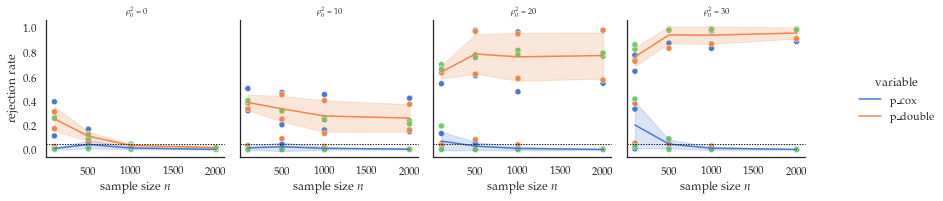

In [157]:
g = sns.FacetGrid(df_rename, col=r'$\rho_0^2$',hue='variable',margin_titles=True)
g.map(
    sns.scatterplot,r'sample size $n$',r'rejection rate',r'kernel $\delta$'
)
g.map(
    sns.lineplot,r'sample size $n$',r'rejection rate',ci='sd'
)
g.add_legend()

g.refline(y=0.05, linewidth=1, linestyle=':',color='k', clip_on=False)
g.set_titles(size='x-small')
# g.refline(x=0.05)
# g.set(xlim=(0,1),ylim=(0,10),yticks=[], ylabel="")
plt.savefig('rejectionrates.pdf')
plt.show()

### DML Example

In [128]:
if 1:
    with open('/Users/bwq666/Documents/BoxHed/sim_data/dml_example2.pkl','rb') as f:
        sim_data = pickle.load(f)

In [129]:
data = pd.melt(
    sim_data,value_vars=['gam_plug','gam_corrected','gam_double'],
)

In [130]:
data['endpoints'] = data['value'].apply(lambda x: x[-1])

In [131]:
longform = data.apply(lambda x: pd.Series(x['value']),axis=1).stack().reset_index(level=1, drop=True)
longform.name = 'values'
df = data.drop('value', axis=1).join(longform).reset_index()

In [132]:
df['time'] = np.tile(np.linspace(0,1,128),3*len(sim_data))

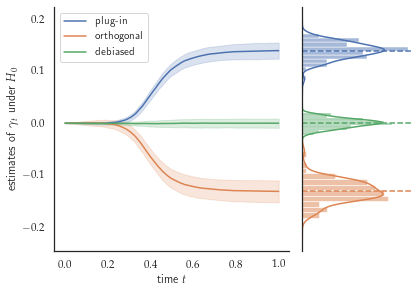

In [136]:
sns.set(style='white',rc={'figure.figsize':(12,12)})

g = sns.JointGrid('time', 'values', data=df, ratio=2)
g.ax_marg_x.remove()
sns.lineplot(data=df,x='time',y='values',hue='variable',ax=g.ax_joint,ci='sd');
h,_ = g.ax_joint.get_legend_handles_labels()
g.ax_joint.legend(h,['plug-in','orthogonal','debiased'], loc=2)
g.ax_joint.set_xlabel(r'time $t$')
g.ax_joint.set_ylabel(r'estimates of $\gamma_t$ under $H_0$')

#g = g.refline(y=0, linewidth=1, linestyle=':',color='k', clip_on=False)

colors = sns.color_palette()
for i,c in enumerate(data['variable'].unique()):
    sns.histplot(y=data['endpoints'][data['variable']==c], ax=g.ax_marg_y, color=colors[i],
        kde=True,kde_kws={'cut':5}
    )
    g.ax_marg_y.axhline(np.mean(data['endpoints'][data['variable']==c]),linestyle='dashed',color=colors[i])

g.figure.tight_layout()
#plt.savefig('endpoints_example.pdf',bbox_inches='tight', pad_inches=0)
plt.show()

In [108]:
np.max(data['endpoints'])

0.5677372004571865

In [49]:
from itertools import product